In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/orl-faces/ORL_faces.npz


In [2]:
# import the library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
print('library loaded')


2024-08-21 15:36:44.355833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 15:36:44.355986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 15:36:44.546361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


library loaded


In [3]:
# Define the path to the dataset
data_path ='/kaggle/input/orl-faces/ORL_faces.npz'
data = np.load(data_path)

train_images = data['trainX']
train_labels = data['trainY']
test_images = data['testX']
test_labels = data['testY']

# Reshape the images to 2D (92x112)
train_images = train_images.reshape(-1, 112, 92)
test_images = test_images.reshape(-1, 112, 92)
print('data loaded')

data loaded


In [4]:
# Define directories
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

In [5]:
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [6]:
# Function to save images
def save_images(images, labels, directory):
    for i, (img, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(directory, str(label))
        os.makedirs(label_dir, exist_ok=True)
        img_path = os.path.join(label_dir, f'{i}.png')
        
        # Convert image to 'L' mode (grayscale) before saving
        img = Image.fromarray(img).convert('L')
        img.save(img_path)

# Save training and testing images
save_images(train_images, train_labels, train_dir)
save_images(test_images, test_labels, test_dir)

# Data Augmentation

In [7]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [8]:
train_generator=train_datagen.flow_from_directory(train_dir,
                                              target_size=(112, 92),
                                              batch_size=32,
                                              class_mode='categorical',shuffle=True,
                                              color_mode='grayscale' )

Found 240 images belonging to 20 classes.


In [9]:
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(test_dir,
                                              target_size=(112, 92),
                                              batch_size=32,
                                              class_mode='categorical',shuffle=True,
                                              color_mode='grayscale' )


Found 160 images belonging to 20 classes.


In [10]:
print(train_labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19]


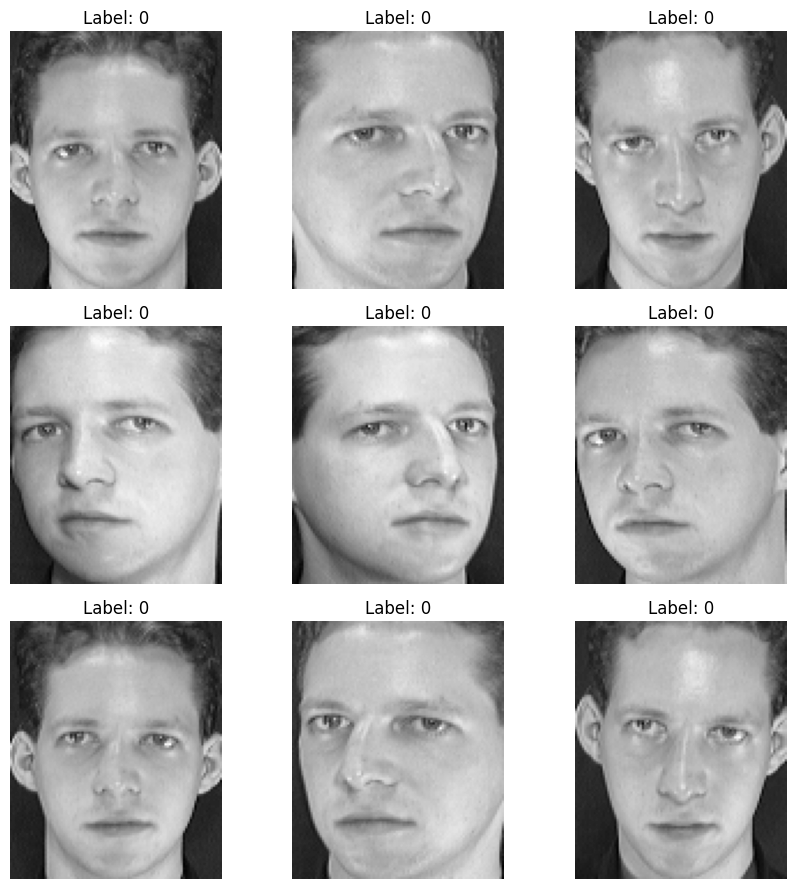

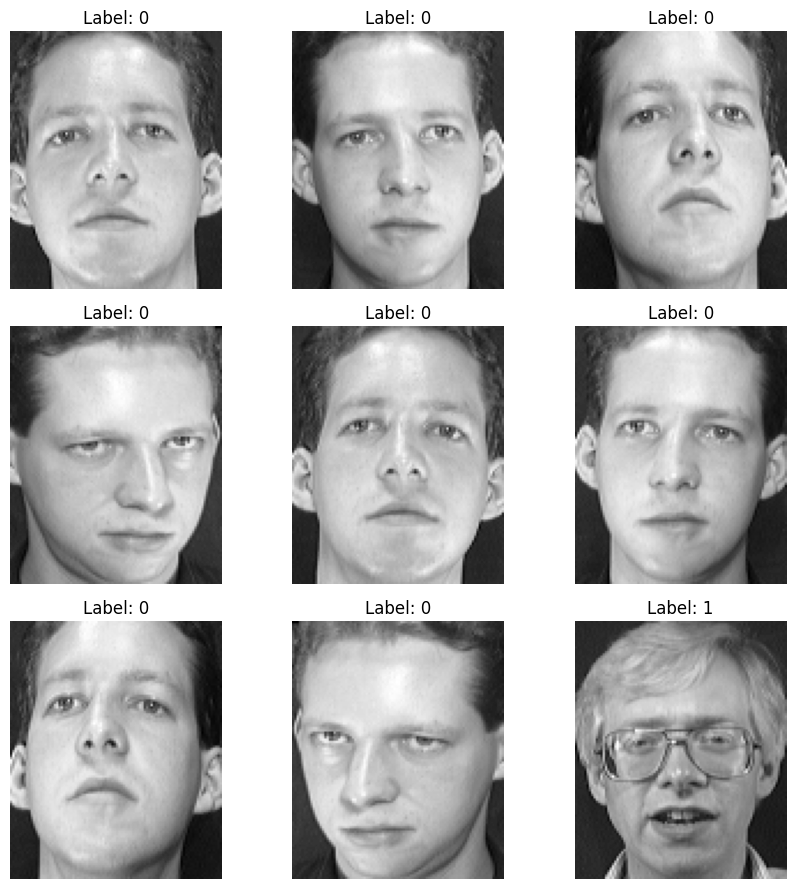

In [11]:
# Define a function to plot images
def plot_images(images, labels, num_images=9):
    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some training images
plot_images(train_images, train_labels)

# Plot some test images
plot_images(test_images, test_labels)


In [12]:
# Convert labels to one-hot encoding
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

In [13]:
# Check the number of unique classes
num_classes = train_labels.shape[1]
num_classes

20

# Simple CNN for Facial Recognition

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


#Model
def create_model():
  model=Sequential()
  model.add(Conv2D(128,(5,5),activation='relu',padding='valid',input_shape=(112, 92, 1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(num_classes,activation='softmax'))
  return model

In [15]:
cnn_model=create_model()
cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 108, 88, 128)   │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 52, 42, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 19, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,052 (3.88 MB)

 Trainable params: 1,016,052 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
# training the model
history_simple_cnn=cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0517 - loss: 3.0055 - val_accuracy: 0.0625 - val_loss: 2.9937
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 963ms/step - accuracy: 0.0488 - loss: 2.9986 - val_accuracy: 0.0500 - val_loss: 2.9957
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 956ms/step - accuracy: 0.0436 - loss: 2.9967 - val_accuracy: 0.0750 - val_loss: 2.9940
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 996ms/step - accuracy: 0.0487 - loss: 2.9948 - val_accuracy: 0.0625 - val_loss: 2.9941
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 900ms/step - accuracy: 0.0437 - loss: 2.9947 - val_accuracy: 0.0500 - val_loss: 2.9944
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 992ms/step - accuracy: 0.0760 - loss: 2.9957 - val_accuracy: 0.0500 - val_loss: 2.9927
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 931ms/step - accuracy: 0.0196 - loss: 3.0001 - val_accuracy: 0.0500 - val_loss: 2.9901
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - accuracy: 0.0501 - loss: 2.9880 - val_accuracy: 0.1125 - val_loss: 2.9771
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.1609 - loss: 2.8040
Test Loss: 2.8160488605499268
Test Accuracy: 0.13750000298023224


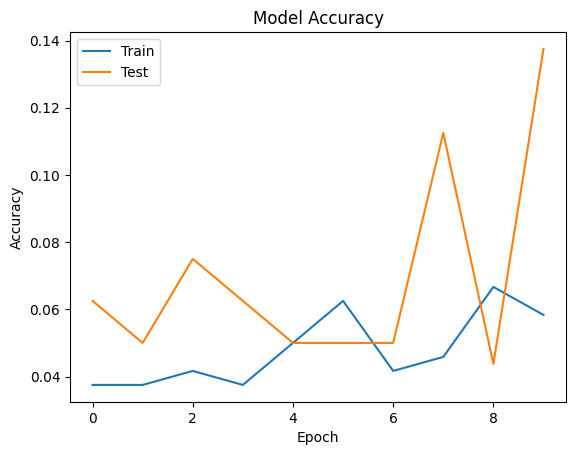

In [18]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(validation_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
# plot the train accuracy vs test accuracy
plt.plot(history_simple_cnn.history['accuracy'])
plt.plot(history_simple_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


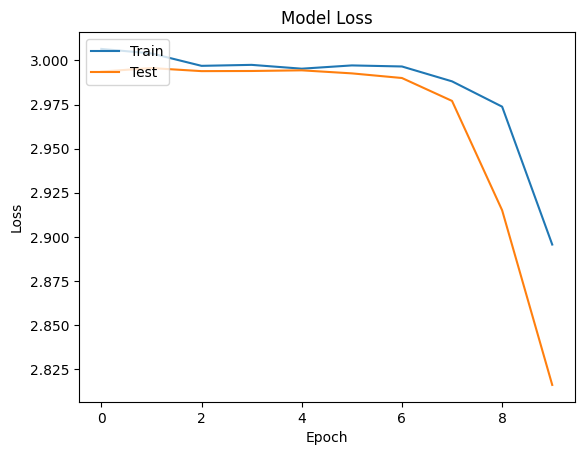

In [19]:
# plot the train loss & test loss
plt.plot(history_simple_cnn.history['loss'])
plt.plot(history_simple_cnn.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [20]:
# save the model
cnn_model.save('cnn_model.h5')

# load the cnn model
cnn_model=tf.keras.models.load_model('cnn_model.h5')
print('model saved')

model saved


In [21]:
# prediction
predictions=cnn_model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


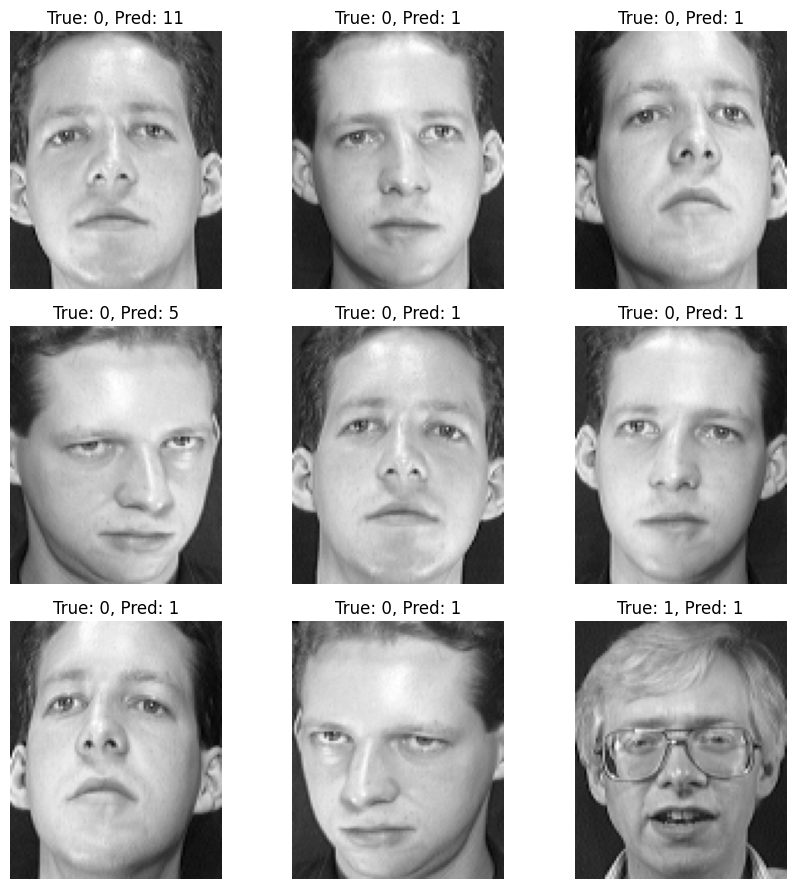

In [22]:
# Visualize some test images with their predicted and true labels
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].reshape(112, 92), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(test_images, true_classes, predicted_classes)

In [23]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

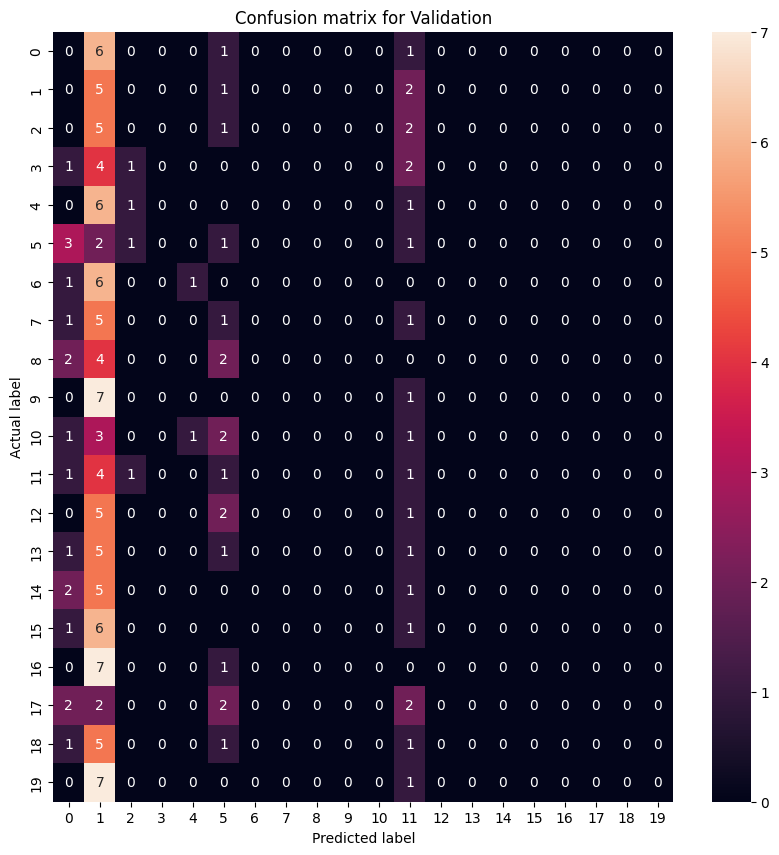

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.05      0.62      0.09         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.06      0.12      0.08         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.05      0.12      0.07         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix for Validation')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print a classification report
print(classification_report(y_true, y_pred))

# Using MobileNet - Pretrained Model

In [25]:
train_generator=train_datagen.flow_from_directory(train_dir,
                                              target_size=(112, 92),
                                              batch_size=32,
                                              class_mode='categorical',shuffle=True,
                                              color_mode='rgb' )

Found 240 images belonging to 20 classes.


In [26]:
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(test_dir,
                                              target_size=(112, 92),
                                              batch_size=32,
                                              class_mode='categorical',shuffle=True,
                                              color_mode='rgb' )

Found 160 images belonging to 20 classes.


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, GlobalAveragePooling2D

# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 92, 3))

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

/tmp/ipykernel_18/1541116887.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 92, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [28]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [29]:
# run
history_mobileNet = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  8/100 ━━━━━━━━━━━━━━━━━━━━ 1:14 813ms/step - accuracy: 0.0633 - loss: 3.3553 - precision: 0.1200 - recall: 0.0112

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 91ms/step - accuracy: 0.1316 - loss: 2.9761 - precision: 0.4512 - recall: 0.0469 - val_accuracy: 0.0500 - val_loss: 5.0758 - val_precision: 0.0896 - val_recall: 0.0375
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.4722 - loss: 1.7345 - precision: 0.7174 - recall: 0.2547 - val_accuracy: 0.1625 - val_loss: 5.3756 - val_precision: 0.2800 - val_recall: 0.1312
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6950 - loss: 1.1604 - precision: 0.8793 - recall: 0.4249 - val_accuracy: 0.1562 - val_loss: 6.3196 - val_precision: 0.2178 - val_recall: 0.1375
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8154 - loss: 0.7508 - precision: 0.9584 - recall: 0.6521 - val_accuracy: 0.1875 - val_loss: 7.2378 - val_precision: 0.2339 - val_recall: 0.1813
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8945 - loss: 0.3645 - precision: 0.9616 - recall: 0.8451 - val_accuracy: 0.1063 - val_loss: 9.3027 

In [30]:
# test accuracy
print('Test Score',model.evaluate(validation_generator))
# test accuracy
print('Train Score',model.evaluate(train_generator))
acc = history_mobileNet.history['accuracy']
val_acc = history_mobileNet.history['val_accuracy']

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.1043 - loss: 8.8280 - precision: 0.1109 - recall: 0.1043
Test Score [8.756937026977539, 0.11249999701976776, 0.11999999731779099, 0.11249999701976776]
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.1450 - loss: 8.6769 - precision: 0.1584 - recall: 0.1450
Train Score [8.795185089111328, 0.15000000596046448, 0.1658986210823059, 0.15000000596046448]


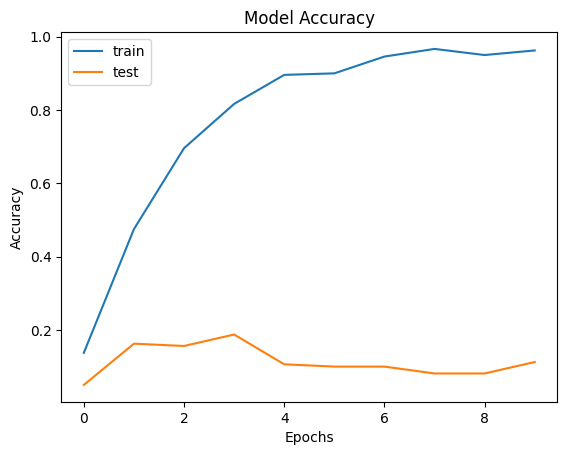

In [31]:
import matplotlib.pyplot as plt

# plot the graph - Train accuracy Vs Validation accuracy.
plt.plot(history_mobileNet.history['accuracy'])
plt.plot(history_mobileNet.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc='best')
plt.show()

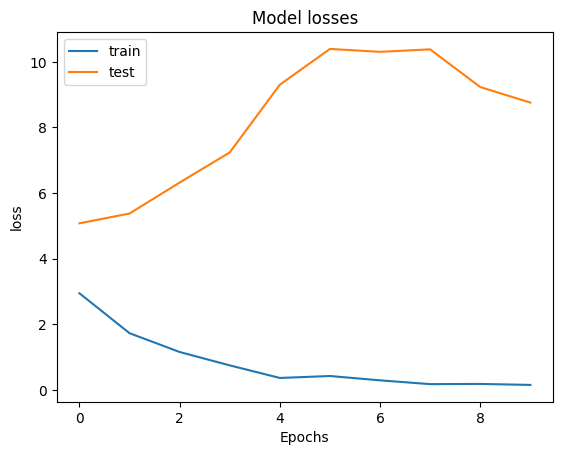

In [32]:
# plot the graph - Train loss Vs Validation loss 
plt.plot(history_mobileNet.history['loss'])
plt.plot(history_mobileNet.history['val_loss'])
plt.title('Model losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='best')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step


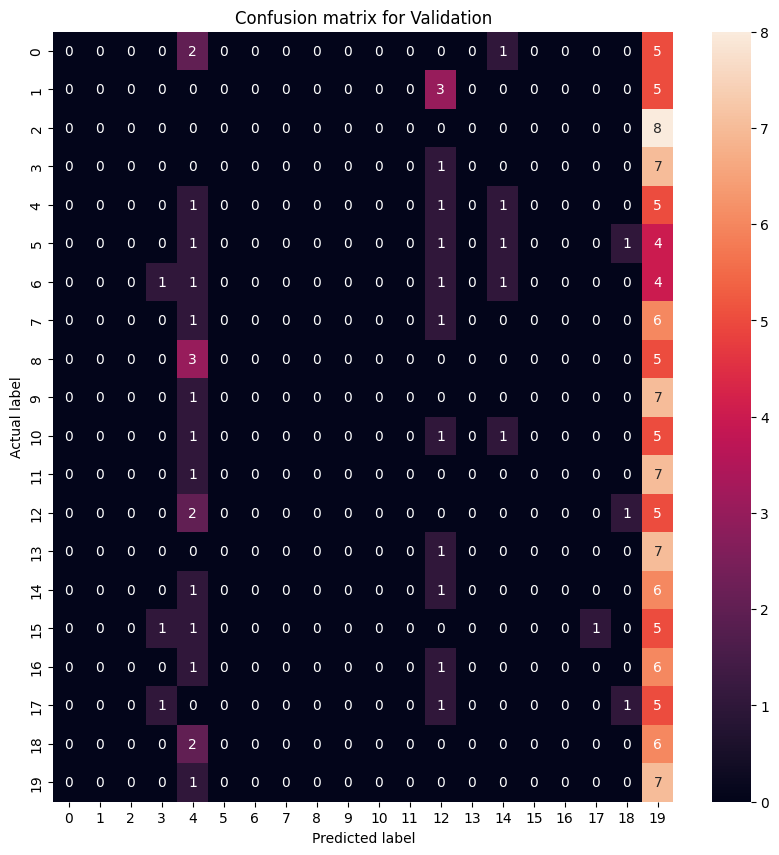

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.05      0.12      0.07         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Get the true labels and predicted labels for Validation
y_true_val = validation_generator.classes
y_pred_prob_val = model.predict(validation_generator)
y_pred_val = np.argmax(y_pred_prob_val, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix for Validation')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print a classification report
print(classification_report(y_true_val, y_pred_val))

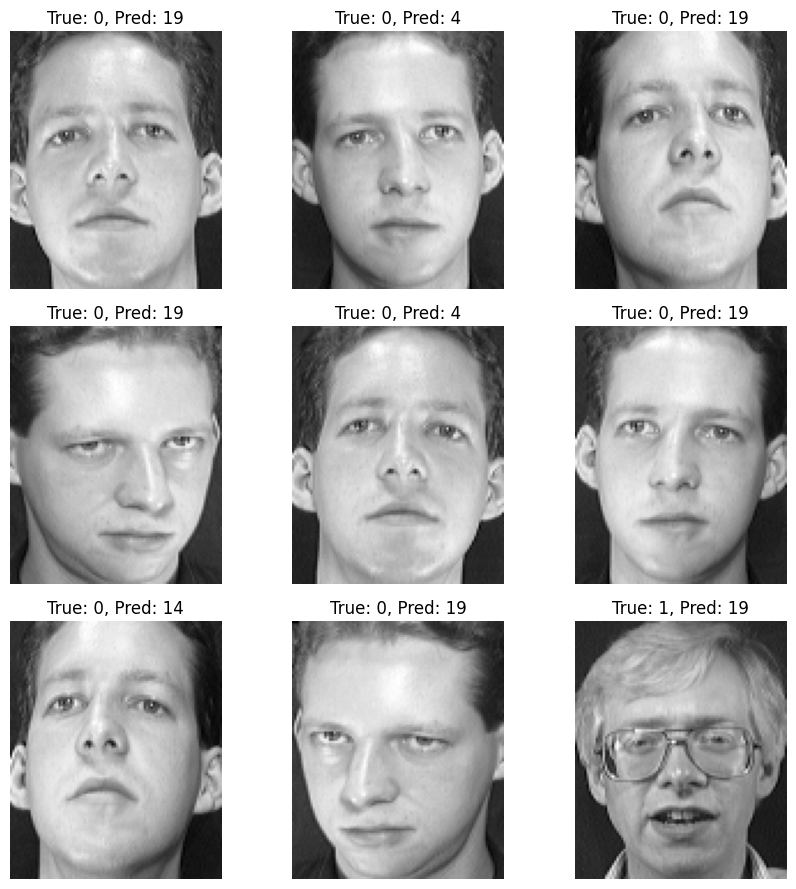

In [34]:
# Visualize some test images with their predicted and true labels
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].reshape(112, 92), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(test_images, y_true_val, y_pred_val)

# Hyperparameter Tuning

In [35]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [36]:
def build_model(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 92, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1))(x)
    x = Dense(hp.Int('units_1', 128, 512, step=64), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1))(x)
    x = Dense(hp.Int('units_2', 64, 256, step=64), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_3', 0.1, 0.5, step=0.1))(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [37]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)


/tmp/ipykernel_18/2520126100.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 92, 3))


In [38]:
tuner.search(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Trial 30 Complete [00h 02m 16s]
val_accuracy: 0.15000000596046448

Best val_accuracy So Far: 0.26875001192092896
Total elapsed time: 00h 42m 36s


In [39]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units_1')} and in the second dense layer is {best_hps.get('units_2')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The optimal dropout rates are {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')}, and {best_hps.get('dropout_3')}.
""")



The optimal number of units in the first dense layer is 256 and in the second dense layer is 256.
The optimal learning rate for the optimizer is 0.0005181886188307158.
The optimal dropout rates are 0.4, 0.1, and 0.5.



In [40]:
model = tuner.hypermodel.build(best_hps)
history_tuner = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

/tmp/ipykernel_18/2520126100.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(112, 92, 3))


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.0644 - loss: 4.3506 - val_accuracy: 0.0875 - val_loss: 3.6468
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 840ms/step - accuracy: 0.1340 - loss: 3.4950 - val_accuracy: 0.1063 - val_loss: 3.8645
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 852ms/step - accuracy: 0.2475 - loss: 2.8215 - val_accuracy: 0.0938 - val_loss: 4.1641
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 870ms/step - accuracy: 0.3292 - loss: 2.4359 - val_accuracy: 0.0938 - val_loss: 4.4170
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 893ms/step - accuracy: 0.4072 - loss: 2.0063 - val_accuracy: 0.1437 - val_loss: 4.8610
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 830ms/step - accuracy: 0.4569 - loss: 1.7386 - val_accuracy: 0.1063 - val_loss: 4.7830
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 913ms/step - accuracy: 0.5418 - loss: 1.4710 - val_accuracy: 0.0938 - val_loss: 4.5843
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 815ms/step - accuracy: 0.7021 - loss: 1.0081 - val_accuracy: 0.1250 - val_loss: 4

In [41]:
# test accuracy
print('Test Score',model.evaluate(validation_generator))
# train accuracy
print('Train Score',model.evaluate(train_generator))
acc = history_tuner.history['accuracy']
val_acc = history_tuner.history['val_accuracy']

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.2293 - loss: 3.9788
Test Score [3.917154312133789, 0.23749999701976776]
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.1272 - loss: 3.7611
Train Score [3.959097146987915, 0.10833333432674408]


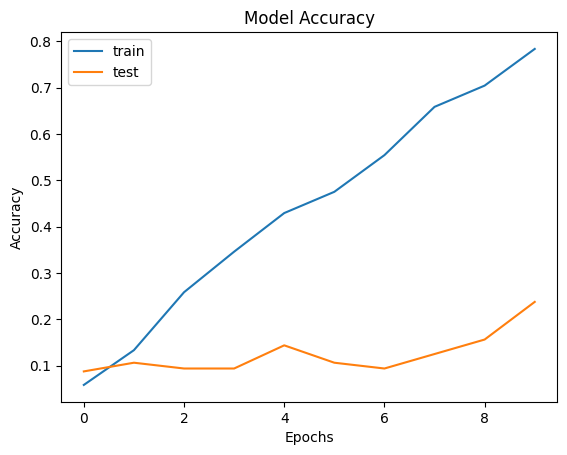

In [42]:
# plot the graph - Train accuracy Vs Validation accuracy.
plt.plot(history_tuner.history['accuracy'])
plt.plot(history_tuner.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc='best')
plt.show()

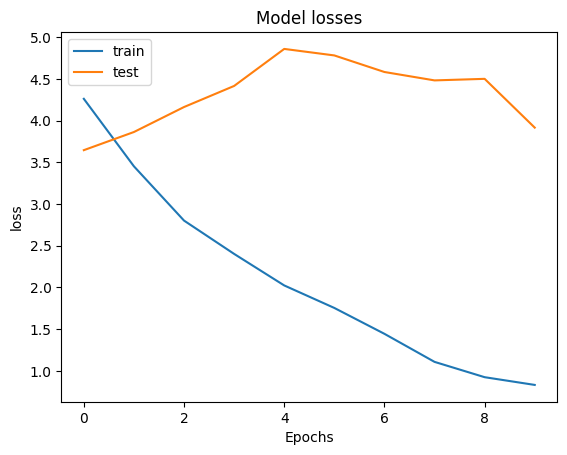

In [43]:
# plot the graph - Train loss Vs Validation loss 
plt.plot(history_tuner.history['loss'])
plt.plot(history_tuner.history['val_loss'])
plt.title('Model losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='best')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


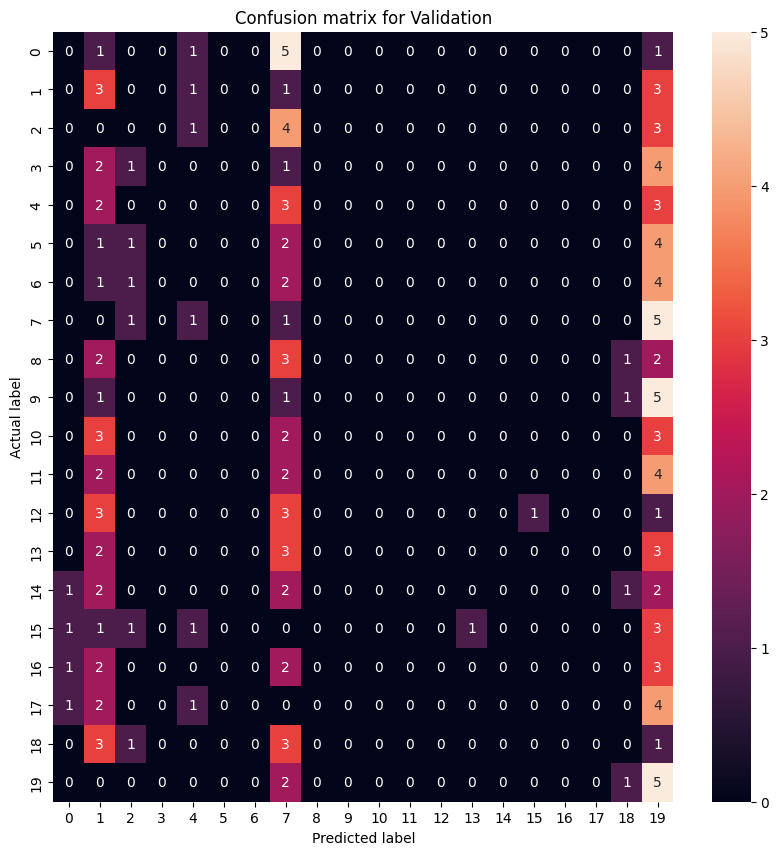

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.09      0.38      0.15         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.02      0.12      0.04         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17       0.00    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Get the true labels and predicted labels for Validation
y_true_val = validation_generator.classes
y_pred_prob_val = model.predict(validation_generator)
y_pred_val = np.argmax(y_pred_prob_val, axis=1)

# Create a confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix for Validation')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Print a classification report
print(classification_report(y_true_val, y_pred_val))

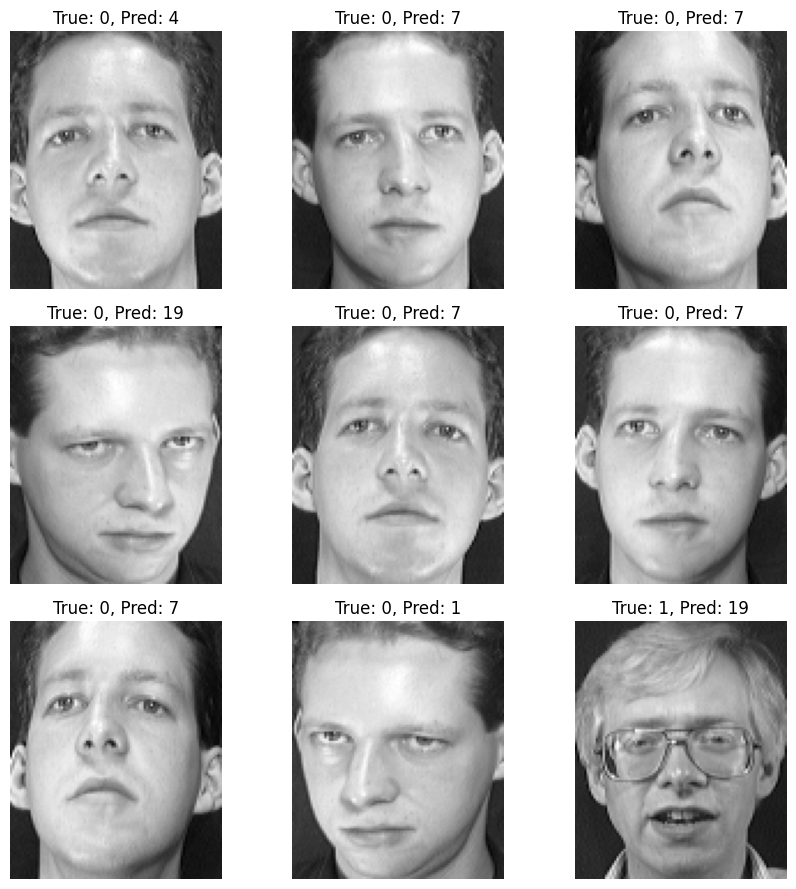

In [45]:
# Visualize some test images with their predicted and true labels
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(9, 9))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].reshape(112, 92), cmap='gray')
        plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(test_images, y_true_val, y_pred_val)

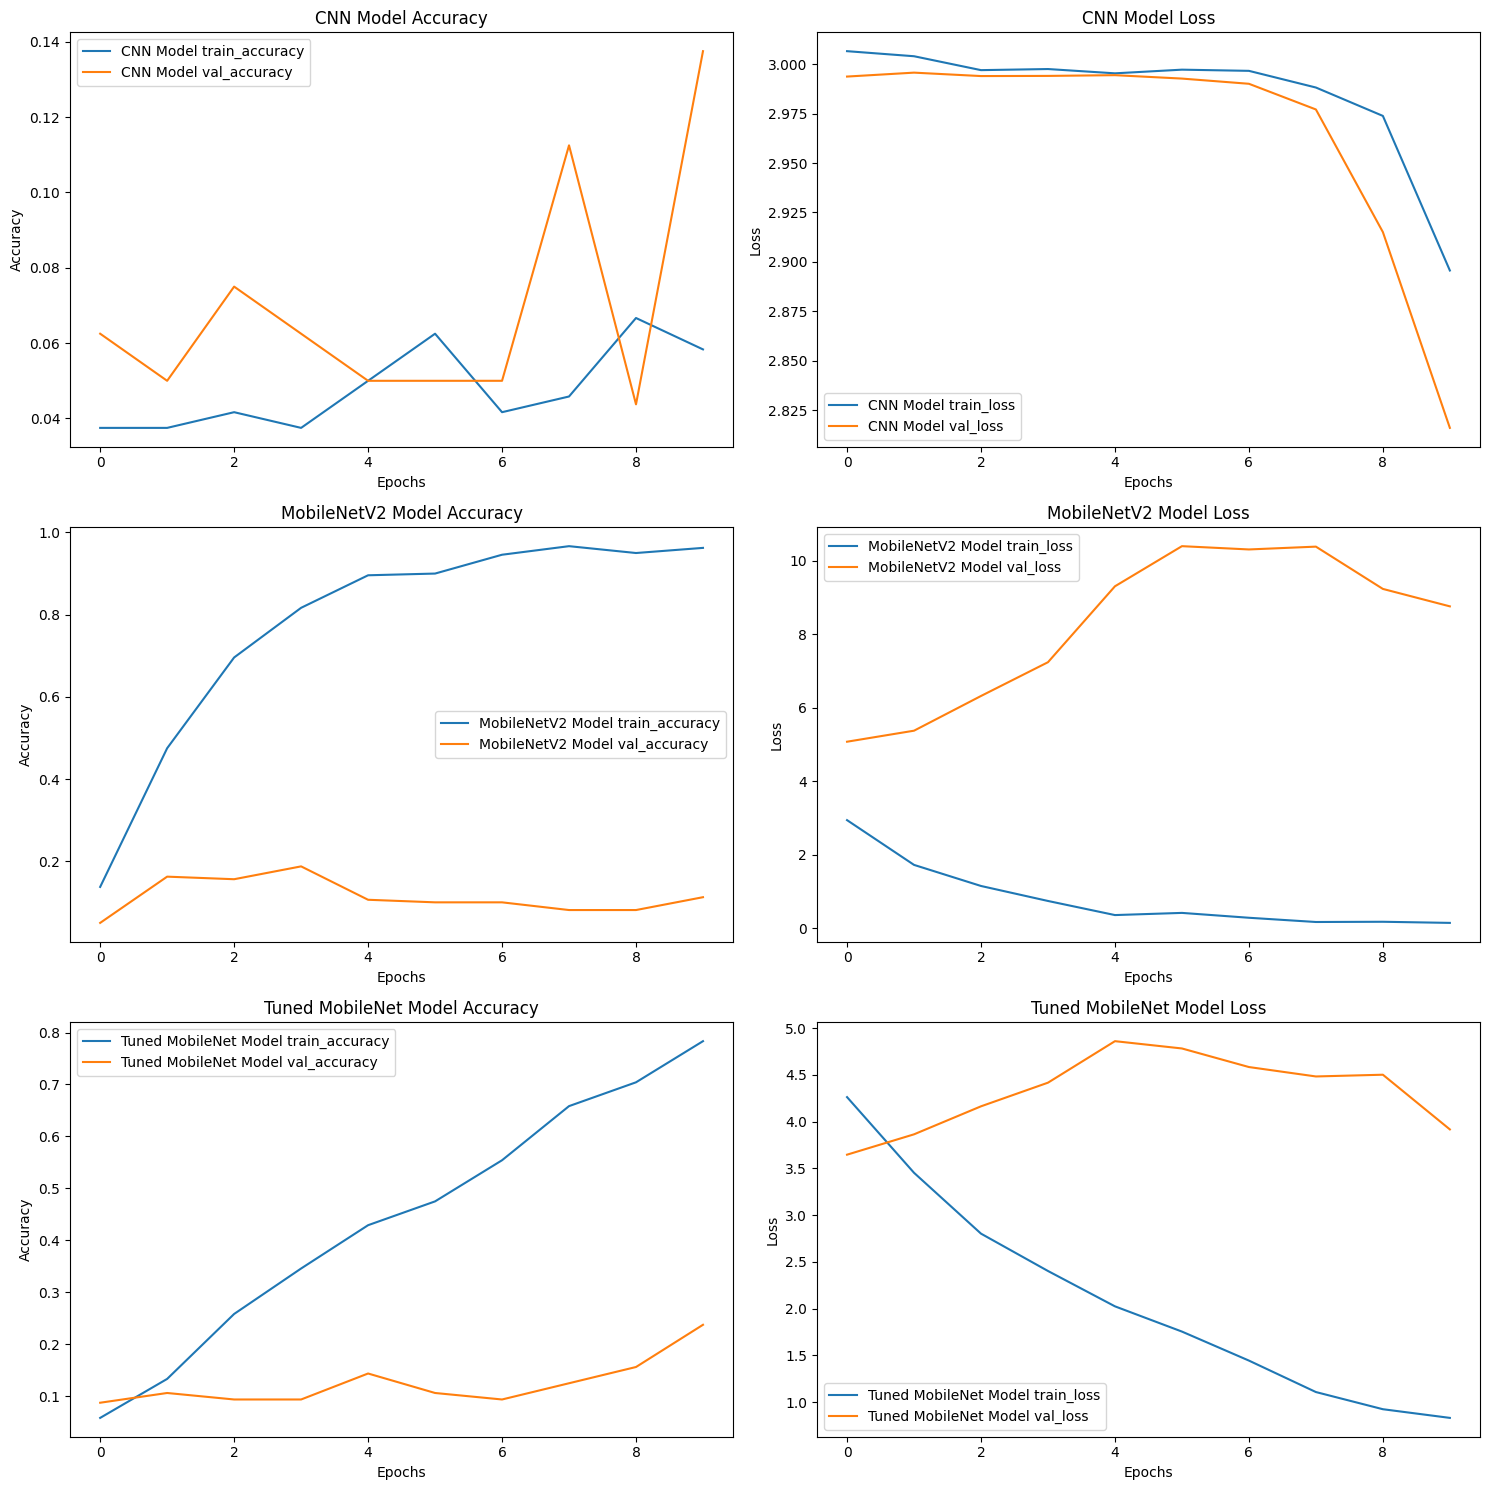

In [46]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_metrics(history, model_name, ax1, ax2):
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label=f'{model_name} train_accuracy')
    ax1.plot(history.history['val_accuracy'], label=f'{model_name} val_accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label=f'{model_name} train_loss')
    ax2.plot(history.history['val_loss'], label=f'{model_name} val_loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

# Assuming you have the history objects for each model
# cnn_history, mobilenet_history, and another_model_history

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot metrics for each model
plot_metrics(history_simple_cnn, 'CNN Model', axs[0, 0], axs[0, 1])
plot_metrics(history_mobileNet, 'MobileNetV2 Model', axs[1, 0], axs[1, 1])
plot_metrics(history_tuner, 'Tuned MobileNet Model', axs[2, 0], axs[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()
